<a href="https://colab.research.google.com/github/Abhishek-Gargha-Maheshwarappa/Reinforcement-Learning-Ad-Campaing-Optimization/blob/master/AD_Campaing_modeling_with_Reinforcemnet_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi Arm Bandit - Thomson Sampling for Ads**


## **1. Abstract** 

Real- World Bernouli trial with exactly two possible outcomes, "success" and "failure." In this since we are doing it for Ads it will be impression or no impression/ 'Click' or 'no Click' on banner ads. Creating the simulation of the ads using random normal distrubtion and then modeling it with thomson smapling with beat distrubtion and trying out different methods and different hyper parameter to obsereve the effect of other techniques like E-greedy, UBC and random Sampling. 


First we setup the necessary imports and the standard Ads. The get_reward_regret samples the reward for the given action, and returns the regret based on the true best action.

## **2. Setting up the enivironment**

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class ADS():
  def __init__(self, ad_camp):
    """
    Ads with rewards 1 or 0.
    
    At initialization, multiple Ads are created. The probability of each Ads
    returning reward 1 if clicked is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.ad_camp = ad_camp
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.ad_camp)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for ad. Assumes actions are 0-indexed
    Args:
      ad_camp is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.ad_camp)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

## **3. Thompson Sampling**

In [30]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the ads with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, ads):
    """
    Args:
      ads: the ads class the algo is trying to model
    """
    self.ads = ads
    self.ad_camp = ads.ad_camp
    self.alpha = np.ones(self.ad_camp)
    self.beta = np.ones(self.ad_camp)
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, ads):
    super().__init__(ads)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, ads):
    super().__init__(ads)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


## **4. Epsilon Greedy**

In [31]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, ads):
    global epsilon
    self.epsilon = epsilon
    self.ads = ads
    self.ad_camp = ads.ad_camp
    self.Q = np.zeros(self.ad_camp) # q-value of actions
    self.N = np.zeros(self.ad_camp) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.ad_camp)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

## **5.Upper-Confidence-Bound**

In [32]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, ads):
    global ucb_c
    self.ucb_c = ucb_c
    self.ads = ads
    self.ad_camp = ads.ad_camp
    self.Q = np.zeros(self.ad_camp) # q-value of actions
    self.N = np.zeros(self.ad_camp) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.ad_camp, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.ads.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

## **6. Plotting different sampling**

In [34]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.xlabel("Episodes")
  plt.ylabel("Regret")
  plt.show()
  
def simulate(simulations, timesteps, ad_camp, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    ads = ADS(ad_camp)
    algo = Algorithm(ads)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(ad_camp, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the ads
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, ad_camp, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

## **7.An example Expierment**

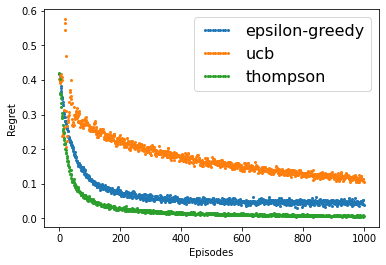

In [35]:

ad_camp = 10 # number of ads
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(ad_camp)

## **8. Hyperparameters**

Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 


# **1. Thompson Sampling Hyperparameter**



1.   Distrubution beta, uniform or other - it is illustrated at the end


#**2. e-greedy**



1.  Epsilon
2.  Decay rate


#**3. UBC**



1.  C -  uncertainty measure is weighed by the hyperparameter  





## **9.E-greedy**
By changing the **epsilon** which is Exploration rate

### **9.1 Experiment 1**

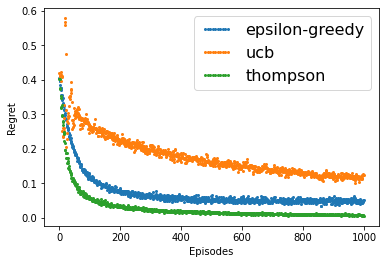

In [ ]:

ad_camp = 10 # number of Ads
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(ad_camp)

### **9.2 Experiment 2**

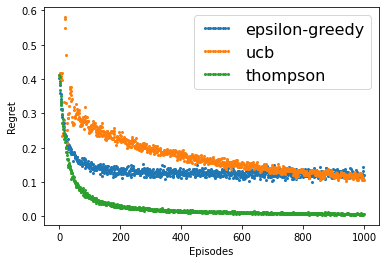

In [ ]:
# Experiment 2
ad_camp = 10 # number of Ads
epsilon = 0.3
ucb_c = 2
stationary=True
experiment(ad_camp)

### **9.3 Experiment 3**

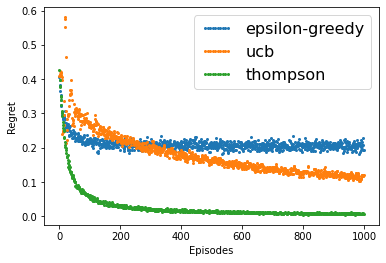

In [ ]:
# Experiment 3
ad_camp = 10 # number of Ads
epsilon = 0.5
ucb_c = 2
stationary=True
experiment(ad_camp)

### **9.4 Experiment 4**

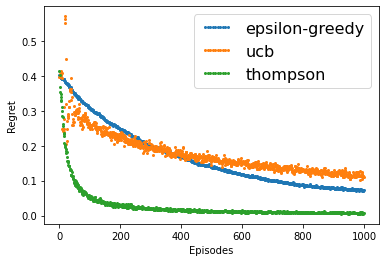

In [ ]:
# Experiment 4
ad_camp = 10 # number of Ads
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

From above it is clear that Epsilon greedy fails when the when we use large value for epsilon, which means more exploration. 

The best value for Epsilon is **0.1**

## **10. UCB**

C - uncertainty measure is weighed by the hyperparameter

### **10.1 Experiment 1**

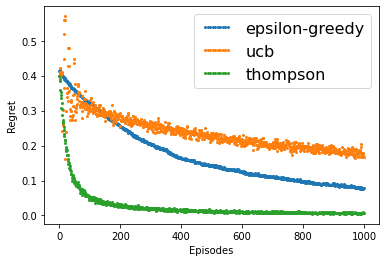

In [ ]:
# Experiment 1
ad_camp = 10 # number of Ads
epsilon = 0.01
ucb_c = 3
stationary=True
experiment(ad_camp)

### **10.2 Experiment 2**

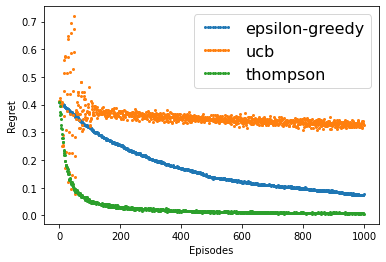

In [ ]:
# Experiment 2
ad_camp = 10 # number of Ads
epsilon = 0.01
ucb_c = 10
stationary=True
experiment(ad_camp)

### **10.3 Experiment 3**

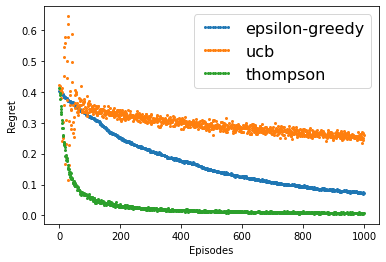

In [ ]:
# Experiment 3
ad_camp = 10 # number of Ads
epsilon = 0.01
ucb_c = 5
stationary=True
experiment(ad_camp)

### **10.4 Experiment 4**

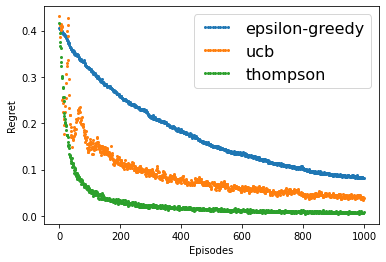

In [ ]:
# Experiment 4
ad_camp = 10 # number of Ads
epsilon = 0.01
ucb_c = 1
stationary=True
experiment(ad_camp)

### **10.5 Experiment 5**

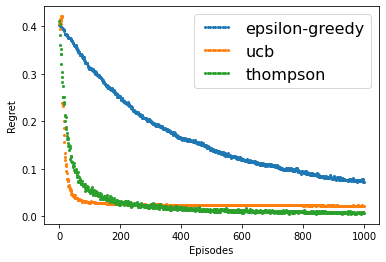

In [ ]:
# Experiment 5
ad_camp = 10 # number of ads
epsilon = 0.01
ucb_c = 0.1
stationary=True
experiment(ad_camp)

From the above experiement of changing c we see that UCB performs well when c decreases, in the final experiement where **c = 0.1** its perfroms is very close to Thompson sampling

How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling?

## **11. Action Space**
The action space can be changed by changing the number of ads 

### **11.1 Ad_campaing =** 10

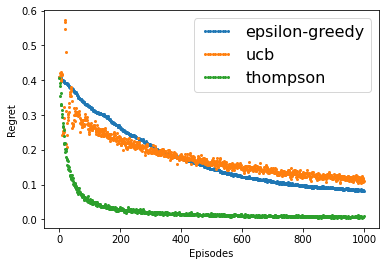

In [ ]:
# Experiment 1
ad_camp = 10 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

## **11.2. Ad_campaing =** 15

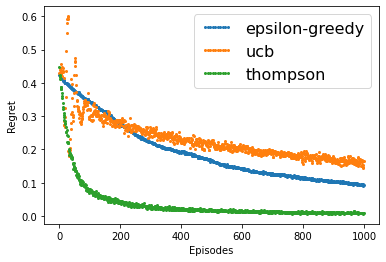

In [ ]:
# Experiment 2
ad_camp = 15 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

### **11.3. Ad_campaing = 25**

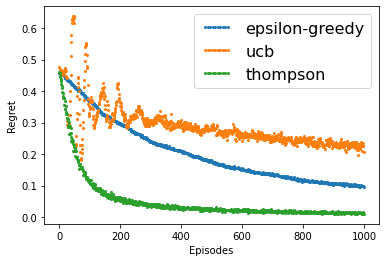

In [ ]:
# Experiment 3
ad_camp = 25 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

## **11.4. Ad_campaing =** 5

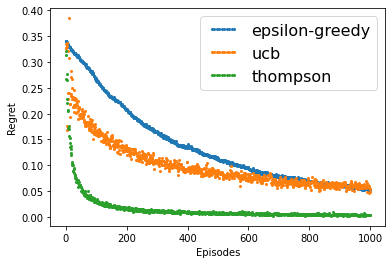

In [ ]:
# Experiment 4
ad_camp = 5 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

## **11.5. Ad_campaing =** 2

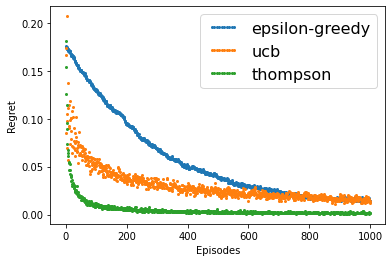

In [ ]:
# Experiment 5
ad_camp = 2 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

Action space will not affect the Thompson sampling as seen by the above experiment, but for the UCB it affects largely, higher action space UCB performs very badly, the E greedy will almost remain fairly the same.

### **12. Stationary affect**

How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling?

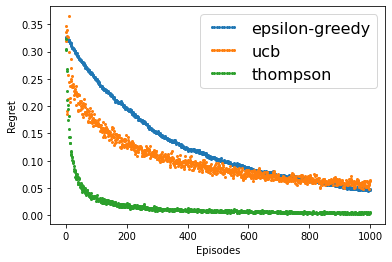

In [ ]:
# Experiment 1
ad_camp = 5 
epsilon = 0.01
ucb_c = 2
stationary=True
experiment(ad_camp)

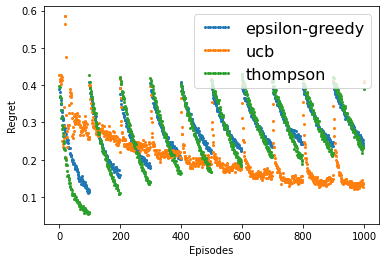

In [ ]:
# Experiment 1
ad_camp = 10
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(ad_camp)

Introducing Non Stationary effect after every 100 steps makes the Regret to move all over the place

When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

## **13. Exploration stoppage**

1. Thompson Sampling will not stop exploration it will keep exploring throughout, when we use beta distribution part of it will overlap with action which is less likely to get good rewards also, which is nothing but exploration. Though the exploration rate is very less compared to exploitation, after many episodes playing the exploration reduces and exploitation increases.

2. In the E-Greedy exploring stops only when epsilon is zero 

3. UCB keeps exploring untill the confidence interval goes a point value

3. Random smapling will always keep exploring throut the life time if there is no condition.

## **Exploitation - Exploration Trade off**

![Alt Text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSofjoQq1pD-CUMS7Q3QPVIt8MUECqaL2vpSA&usqp=CAU)

The exploration-exploitation trade-off is a well-known dilemma of Reinforcement Learning where agent has choose between exploring the environment and exploiting the knowledge of the enivronment.

When agent start exploring environment it starts to learn from it and the agent exploration decerases.

This exploration and exploitation trade off can be controlled by exploration rate.

### **13.1. Epsilon Greedy Strategy**

To get this balance between exploitation and exploration, epsilon greedy strategy can be used. With this strategy, we define an exploration rate  that we initially set to . This exploration rate is the probability that our agent will explore the environment rather than exploit it. With Epslion 1, it is 100% certain that the agent will start out by exploring the environment.

As the agent learns more about the environment, at the start of each new episode, epsilon will decay by some rate that we set so that the likelihood of exploration becomes less and less probable as the agent learns more and more about the environment. The agent will become “greedy” in terms of exploiting the environment once it has had the opportunity to explore and learn more about it.


## **14. Thompson sampling with different distrubtion**

Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

We take a example of the slot machine and try out different distrubution

## **14.1 Defining the slot machine and genrating data**

In [17]:
import numpy as np

In [18]:
#Define the total number of turns (i.e., the number of times we will play a slot machine).
#Remember, we have $1,000 available, and each turn costs $1. We thus have 1,000 turns.
number_of_turns = 1000

#define the total number of slot machines
number_of_slot_machines = 6

#Define arrays where we can keep track of our wins (positive rewards) 
#and losses (negative rewards) for each slot machine.
#number_of_positive_rewards = np.zeros(number_of_slot_machines)
#number_of_negative_rewards = np.zeros(number_of_slot_machines)

#define a seed for the random number generator (to ensure that results are reproducible)
np.random.seed(5)

#create a random conversion rate between 1% and 15% for each slot machine
conversion_rates = np.random.uniform(0.01, 0.15, number_of_slot_machines)

#Show conversion rates for each slot machine. Remember that in a real-world scenario
#the decision-maker would not know this information!
for i in range(6):
  print('Conversion rate for slot machine {0}: {1:.2%}'.format(i, conversion_rates[i]))

Conversion rate for slot machine 0: 4.11%
Conversion rate for slot machine 1: 13.19%
Conversion rate for slot machine 2: 3.89%
Conversion rate for slot machine 3: 13.86%
Conversion rate for slot machine 4: 7.84%
Conversion rate for slot machine 5: 9.56%


In [19]:
#The data set is a matrix with one row for each turn, and one column for each slot machine.
#Each item in the matrix represents the outcome of what would happen if we were to play a  
#particular slot machine on that particular turn. A value of "1" indicates that we would win, 
#while a value of "0" indicates that we would lose. The number of "wins" for each slot machine
#is determined by its conversion rate.
outcomes = np.zeros((number_of_turns, number_of_slot_machines)) #create a two-dimensional numpy array, and fill it with zeros
for turn_index in range(number_of_turns): #for each turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Get a random number between 0.0 and 1.0.
        #If the random number is less than or equal to this slot machine's conversion rate, then set the outcome to "1".
        #Otherwise, the outcome will be "0" because the entire matrix was initially filled with zeros.
        if np.random.rand() <= conversion_rates[slot_machine_index]:
            outcomes[turn_index][slot_machine_index] = 1

#display the first 15 rows of data
print(outcomes[0:15, 0:6]) #this sort of indexing means "rows 0 to 14" (i.e., the first 15 rows) and "columns 0 through 5" (i.e., the first six columns)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


In [20]:
#show means (i.e., conversion rates) for each column (i.e., for each slot machine)
for i in range(6):
  print('Mean for column {0}: {1:.2%}'.format(i, np.mean(outcomes[:, i])))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Mean for column 0: 4.90%
Mean for column 1: 10.70%
Mean for column 2: 3.20%
Mean for column 3: 13.60%
Mean for column 4: 7.60%
Mean for column 5: 8.70%
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


## **14.2 Normal Distrubution**

In [ ]:
#for each turn
rewards = [[0] for i in range(number_of_slot_machines)]
for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta

    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        #a = number_of_positive_rewards[slot_machine_index] + 1
        #b = number_of_negative_rewards[slot_machine_index] + 1
        mean = np.mean(rewards[slot_machine_index])

        std = np.std(rewards[slot_machine_index])
        #Get a random value from the beta distribution whose shape is defined by the number of
        #wins and losses that have thus far been observed for this slot machine
        random_beta = np.random.normal(mean, std)
        #print(random_beta)

        #if this is the largest beta value thus far observed for this iteration
        if random_beta > max_beta:
            max_beta = random_beta #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
        rewards[index_of_machine_to_play].append(1)
    else:
        rewards[index_of_machine_to_play].append(0)

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played

number_of_times_played = [0 for i in range(number_of_slot_machines)]
for n in range (number_of_slot_machines):
  number_of_times_played[n] =len(rewards[n])

#number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Number of turns 1000:
Slot machine 0 was played 262 times that is, 26.20%
Slot machine 1 was played 319 times that is, 31.90%
Slot machine 2 was played 130 times that is, 13.00%
Slot machine 3 was played 277 times that is, 27.70%
Slot machine 4 was played 17 times that is, 1.70%
Slot machine 5 was played 1 times that is, 0.10%

Overall Conclusion: The best slot machine to play is machine 1!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


## **14.3 Gamma Distrubution**

In [ ]:
#for each turn
number_of_turns = 1000
number_of_positive_rewards = np.zeros(number_of_slot_machines)
number_of_negative_rewards = np.zeros(number_of_slot_machines)
for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta
    random_beta = 0
    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        a = number_of_positive_rewards[slot_machine_index] + 1
        b = number_of_negative_rewards[slot_machine_index] + 1
        k=a/(a+b)
  

        random_beta = np.random.gamma(k,turn_index)


        #if this is the largest beta value thus far observed for this iteration
        if random_beta > max_beta:
            max_beta = random_beta #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
      number_of_positive_rewards[index_of_machine_to_play] += 1
    else:
      number_of_negative_rewards[index_of_machine_to_play] += 1

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played

number_of_times_played = number_of_positive_rewards + number_of_negative_rewards

#number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Number of turns 1000:
Slot machine 0 was played 89.0 times that is, 8.90%
Slot machine 1 was played 156.0 times that is, 15.60%
Slot machine 2 was played 88.0 times that is, 8.80%
Slot machine 3 was played 325.0 times that is, 32.50%
Slot machine 4 was played 158.0 times that is, 15.80%
Slot machine 5 was played 184.0 times that is, 18.40%

Overall Conclusion: The best slot machine to play is machine 3!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


## **14.2 Binomial Distrubution**

In [ ]:
#for each turn
number_of_turns = 1000
number_of_positive_rewards = np.zeros(number_of_slot_machines)
number_of_negative_rewards = np.zeros(number_of_slot_machines)
for turn_index in range(number_of_turns):
    index_of_machine_to_play = -1
    max_beta = -1 # note that max beta
    random_beta = 0
    #determine which slot machine to play for this turn
    for slot_machine_index in range(number_of_slot_machines): #for each slot machine
        #Define the shape parameters for the beta distribution. The shape will depend on the number
        #of wins and losses that have thus far been observed for this particular slot machine.
        a = number_of_positive_rewards[slot_machine_index] + 1
        b = number_of_negative_rewards[slot_machine_index] + 1
        k=a/(a+b)
        #Get a random value from the beta distribution whose shape is defined by the number of
        #wins and losses that have thus far been observed for this slot machine

        random_beta = np.random.binomial(turn_index, k)
        
        #if this is the largest beta value thus far observed for this iteration
        if random_beta > max_beta:
            max_beta = random_beta #update the maximum beta value thus far observed
            index_of_machine_to_play = slot_machine_index #set the machine to play to the current machine
    
    #play the selected slot machine, and record whether we win or lose
    if outcomes[turn_index][index_of_machine_to_play] == 1:
      number_of_positive_rewards[index_of_machine_to_play] += 1
    else:
      number_of_negative_rewards[index_of_machine_to_play] += 1

print('Number of turns {0}:'.format(number_of_turns))  

#compute and display the total number of times each slot machine was played

number_of_times_played = number_of_positive_rewards + number_of_negative_rewards

#number_of_times_played = number_of_positive_rewards + number_of_negative_rewards 
for slot_machine_index in range(number_of_slot_machines): #for each slot machine
    print('Slot machine {0} was played {1} times that is, {2:.2%}'.format(slot_machine_index, number_of_times_played[slot_machine_index], (number_of_times_played[slot_machine_index]/number_of_turns)))

#identify and display the best slot machine to play
print('\nOverall Conclusion: The best slot machine to play is machine {}!'.format(np.argmax(number_of_times_played)))

#show true conversion rate
for i in range(6):
  print('True conversion rate for column {0}: {1:.2%}'.format(i, conversion_rates[i]))  

Number of turns 1000:
Slot machine 0 was played 27.0 times that is, 2.70%
Slot machine 1 was played 768.0 times that is, 76.80%
Slot machine 2 was played 11.0 times that is, 1.10%
Slot machine 3 was played 11.0 times that is, 1.10%
Slot machine 4 was played 138.0 times that is, 13.80%
Slot machine 5 was played 45.0 times that is, 4.50%

Overall Conclusion: The best slot machine to play is machine 1!
True conversion rate for column 0: 4.11%
True conversion rate for column 1: 13.19%
True conversion rate for column 2: 3.89%
True conversion rate for column 3: 13.86%
True conversion rate for column 4: 7.84%
True conversion rate for column 5: 9.56%


## **15. Past actions with different sampling**

How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions?

1. Thompson sampling remembers the past action in the fomr of distrubtion thats how it remember the pervious action, which can be exploited.

2. E- greedy - also remembers the pervious actions in the form of action and reward, which it will exploit.

3. UBC -  it actual remembers because with which we can find less explored or uncertain action which has big confindence interval.

4. Random doesnt even remeber anything from past its action are completely random

## **Conclusion**

We can conclude that the hyperparameters affect the performance of each of the sampling techniques, non stationary has large affect on the performance of smapling.

Using other distrubution to like binomial and gamma does affect output sometimes giving output not matching the data generated.


## **Reference**

* Nicholas Brown -Reinforcement Learning - Thompson Sampling & the Multi-Armed Bandit Problem [link](https://colab.research.google.com/drive/1gdR7k7jtSRqYnPNHcbAKdIjGRjQXpfnA)  
* Andre Cianflone - Thompson sampling - 
*   Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017). [link](https://arxiv.org/abs/1707.02038)

* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.


I have referred the above links and used to code for the above notebook and made necessary changes where ever required.

Copyright 2020 Abhishek Maheshwarappa

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.